<a href="https://colab.research.google.com/github/bborisggg/finance_case/blob/main/portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1807]:
#pip install pyportfolioopt

У данных вычислений есть набор параметров: каждый раз когда мы делаем выбор между активами различной доходности / волатильности мы учитываем склонность к риску инвестора. При этом для получения сбалансированного портфеля относительно различных активов может быть различная склонность к риску

Несклонность к риску относительно гос. облигаций

In [1808]:
risk_aversion_1 = 0.1

Несклонность к риску относительно корпоративных облигаций, при одинаковом уровне риска эмитетнта

In [1809]:
risk_aversion_2 = 1

Несклонность к риску относительно корпоративных облигаций, при различном уровне риска эмитетнта

In [1810]:
risk_aversion_3 = 4

При расчетах для облигаций в целом берем высокий показатель, так как эта часть портфеля должна быть наиболее надежной, доходность можем получить и благодаря акциям

In [1811]:
risk_aversion_b = 20

Несклонность к риску относительно акций

In [1812]:
risk_aversion_4 = 0.5

Несклонность к риску относительно выбора между акциями и облигациями

In [1813]:
risk_aversion_5 = 2

Также к параметрам модели относятся значения ERP и безрисковой ставки процента. Мы берем эти значения из экспертных оценок (для ERP), а также из кривой бескупонной доходности Банка Росии

In [1814]:
ERP = 0.05
RF = 0.1225

In [1815]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

In [1816]:
df = pd.read_excel('quotes.xlsx',sheet_name=0)

In [1817]:
df.set_index('TRADEDATE',inplace=True)
df.index = pd.to_datetime(df.index)

In [1818]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage, exp_cov

In [1819]:
mu = mean_historical_return(df,frequency=12)
#S = exp_cov(df,frequency=12)
S = CovarianceShrinkage(df,frequency=12).ledoit_wolf(shrinkage_target='single_factor')

In [1820]:
mu

RUGBITR1Y    0.063825
RUGBITR3Y    0.063528
RUGBITR5Y    0.054831
RUGBITR5+    0.044322
dtype: float64

Берем доходность из кривой бескупонной доходности: то, на что должен ориентироваться инвестор. Так как собираем портфель для долгосрочного инвестирования, берем доходности будущих периодов. Через 4 года кривая бескупонной доходности снова становится возрастающей, ориентируемся на этот участок

In [1821]:
mu['RUGBITR1Y'] = ((1+0.1216)**5 / (1+0.1216)**4 )**(1/1) - 1
mu['RUGBITR3Y'] = ((1+0.1217)**7 / (1+0.1216)**4 )**(1/3) - 1
mu['RUGBITR5Y'] = ((1+0.1220)**9 / (1+0.1216)**4 )**(1/5) - 1
mu['RUGBITR5+'] = ((1+0.1225)**14 / (1+0.1216)**4 )**(1/10) - 1

In [1822]:
S

,RUGBITR1Y,RUGBITR3Y,RUGBITR5Y,RUGBITR5+
RUGBITR1Y,0.000372,0.000637,0.001018,0.001486
RUGBITR3Y,0.000637,0.002178,0.003596,0.005349
RUGBITR5Y,0.001018,0.003596,0.006915,0.010225
RUGBITR5+,0.001486,0.005349,0.010225,0.016813


0.12161297869490459 0.019907975764135284


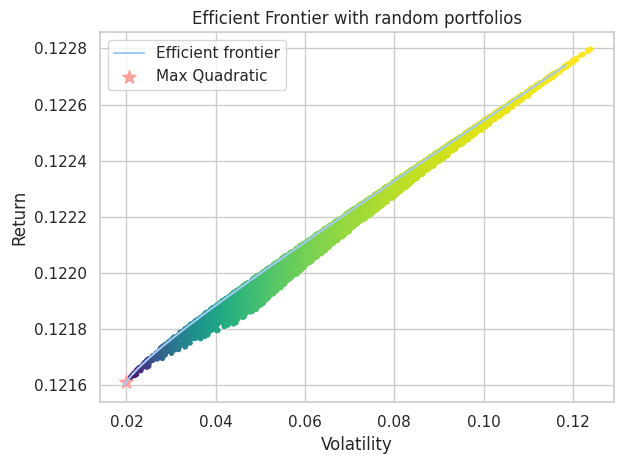

In [1823]:
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, plotting
import matplotlib.pyplot as plt
import numpy as np

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False,show_tickers =True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)

#w = ef2.max_sharpe()
w = ef2.max_quadratic_utility(risk_aversion=risk_aversion_2)
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
print(ret_tangent, std_tangent)

# Plot random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Quadratic")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
#ef2.clean_weights(), mu, S

In [1824]:
ww= ef2.clean_weights()
weights_state_bonds = pd.Series(ww, index=ww.keys()).to_frame()

In [1825]:
aggr_state_bonds = pd.DataFrame({'State Bonds':0},index = df.index)

In [1826]:
for column in ['RUGBITR1Y','RUGBITR3Y','RUGBITR5Y','RUGBITR5+']:
  aggr_state_bonds['State Bonds'] += weights_state_bonds.loc[column][0] * df[column] / df[column].iloc[0]

In [1827]:
aggr_state_bonds

,State Bonds
TRADEDATE,
2013-01-01,1.000000
2013-02-01,1.001487
2013-03-01,1.004437
2013-04-01,1.009134
2013-05-01,1.011655
...,...
2023-08-01,1.930853
2023-09-01,1.924423
2023-10-01,1.938470


In [1828]:
mu_state_bonds = ret_tangent

In [1829]:
mu_state_bonds

0.12161297869490459

In [1830]:
mu_state_bonds_all = mu

Теперь сделаем расчет для корпоративных облигаций, сначала рейтинга AAA

In [1831]:
df = pd.read_excel('quotes.xlsx',sheet_name=1)

In [1832]:
df.set_index('TRADEDATE',inplace=True)
df.index = pd.to_datetime(df.index)
df = df[['RUCBTR3A3YNS','RUCBTR3A5YNS']]

In [1833]:
mu = mean_historical_return(df,frequency=12)
S = exp_cov(df,frequency=12)

In [1834]:
mu

RUCBTR3A3YNS    0.062189
RUCBTR3A5YNS    0.056038
dtype: float64

Для прогноза доходностей корпоративных облигаций воспользуемся значениями доходности гос. облигаций и добавим премию за риск. Для этого возьмем медианный спред доходностей между индексом гос. облигаций и корпоративных облигаций за последний месяц


In [1835]:
mu['RUCBTR3A3YNS'] = mu_state_bonds_all['RUGBITR3Y'] + 0.0134
mu['RUCBTR3A5YNS'] = mu_state_bonds_all['RUGBITR5Y'] + 0.0106

In [1836]:
mu

RUCBTR3A3YNS    0.135233
RUCBTR3A5YNS    0.132920
dtype: float64

In [1837]:
S

,RUCBTR3A3YNS,RUCBTR3A5YNS
RUCBTR3A3YNS,0.002384,0.004282
RUCBTR3A5YNS,0.004282,0.008242


0.13523334776613852 0.048821584982527685


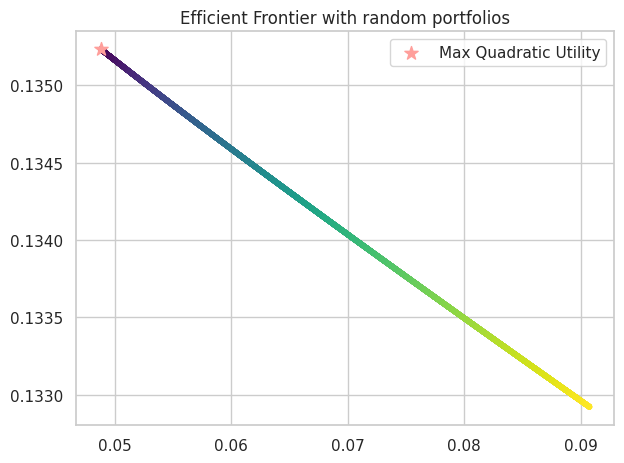

In [1838]:
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, plotting
import matplotlib.pyplot as plt
import numpy as np

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
#plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False,show_tickers =True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)

#w = ef2.max_sharpe()
w = ef2.max_quadratic_utility(risk_aversion=risk_aversion_2)
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
print(ret_tangent, std_tangent)

# Plot random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Quadratic Utility")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
#ef2.clean_weights(), mu, S

In [1839]:
ww= ef2.clean_weights()
weights_corp_bonds_AAA = pd.Series(ww, index=ww.keys()).to_frame()

In [1840]:
weights_corp_bonds_AAA

,0
RUCBTR3A3YNS,1.0
RUCBTR3A5YNS,0.0


Получаем, что выгоднее собирать портфель только из корпоративных облигаций ААА только сроком до трех лет

In [1841]:
mu_corp_bonds_AAA = mu['RUCBTR3A3YNS']
aggr_corp_bonds_AAA = pd.DataFrame({'Corporate Bonds AAA':df['RUCBTR3A3YNS']},index = df.index)

Теперь для AA-эмитентов

In [1842]:
df = pd.read_excel('quotes.xlsx',sheet_name=1)

In [1843]:
df.set_index('TRADEDATE',inplace=True)
df.index = pd.to_datetime(df.index)
df = df[['RUCBTRAA3YNS','RUCBTRAA5YNS']]

In [1844]:
mu = mean_historical_return(df,frequency=12)
S = exp_cov(df,frequency=12)

In [1845]:
mu['RUCBTRAA3YNS'] = mu_state_bonds_all['RUGBITR3Y'] + 0.0244
mu['RUCBTRAA5YNS'] = mu_state_bonds_all['RUGBITR5Y'] + 0.0254

0.14623334710111205 0.058128585603227145


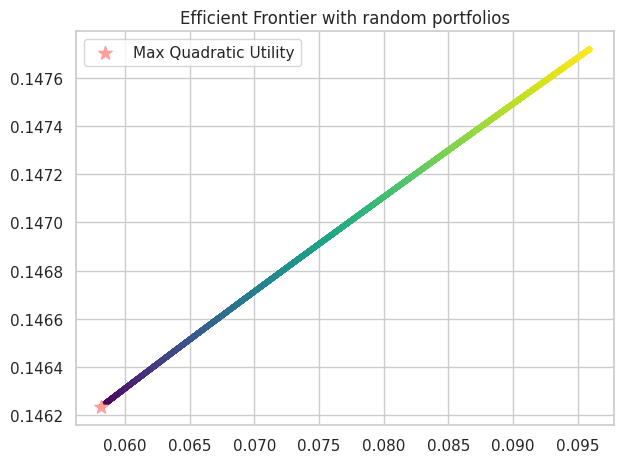

In [1846]:
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, plotting
import matplotlib.pyplot as plt
import numpy as np

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
#plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False,show_tickers =True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)

#w = ef2.max_sharpe()
w = ef2.max_quadratic_utility(risk_aversion=risk_aversion_2)
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
print(ret_tangent, std_tangent)

# Plot random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Quadratic Utility")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
#ef2.clean_weights(), mu, S

In [1847]:
ww = ef2.clean_weights()
weights_corp_bonds_AA = pd.Series(ww, index=ww.keys()).to_frame()

In [1848]:
weights_corp_bonds_AA

,0
RUCBTRAA3YNS,1.0
RUCBTRAA5YNS,0.0


In [1849]:
aggr_corp_bonds_AA = pd.DataFrame({'Corporate Bonds AA':0},index = df.index)

In [1850]:
for column in ['RUCBTRAA3YNS','RUCBTRAA5YNS']:
  aggr_corp_bonds_AA['Corporate Bonds AA'] += weights_corp_bonds_AA.loc[column][0] * df[column] / df[column].iloc[0]

In [1851]:
mu_corp_bonds_AA= ret_tangent

Теперь объединим корпоративные облигации в один портфель

In [1852]:
df = pd.DataFrame({'Corporate Bonds AA':aggr_corp_bonds_AA['Corporate Bonds AA'],'Corporate Bonds AAA':aggr_corp_bonds_AAA['Corporate Bonds AAA']},index = df.index)

In [1853]:
mu = mean_historical_return(df,frequency=12)
S = exp_cov(df,frequency=12)

In [1854]:
mu['Corporate Bonds AAA'] = mu_corp_bonds_AAA
mu['Corporate Bonds AA'] = mu_corp_bonds_AA

0.14623330228002157 0.058128545429082766


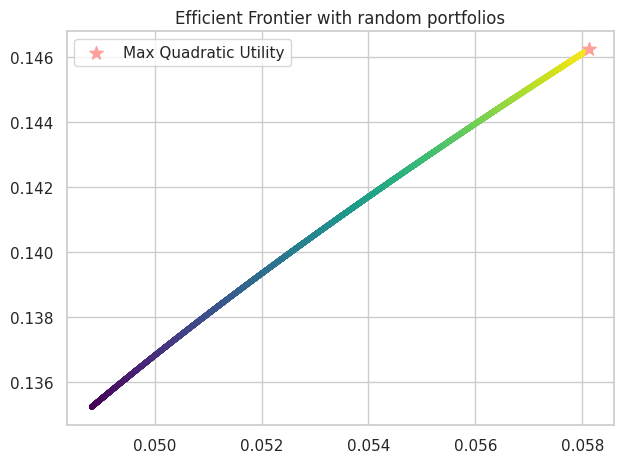

In [1855]:
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, plotting
import matplotlib.pyplot as plt
import numpy as np

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
#plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False,show_tickers =True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)

#w = ef2.max_sharpe()
w = ef2.max_quadratic_utility(risk_aversion=risk_aversion_3)
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
print(ret_tangent, std_tangent)

# Plot random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Quadratic Utility")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
#ef2.clean_weights(), mu, S

In [1856]:
ww = ef2.clean_weights()
weights_corp_bonds = pd.Series(ww, index=ww.keys()).to_frame()

In [1857]:
aggr_corp_bonds = pd.DataFrame({'Corporate Bonds':0},index = df.index)

In [1858]:
for column in ['Corporate Bonds AAA','Corporate Bonds AA']:
  aggr_corp_bonds['Corporate Bonds'] += weights_corp_bonds.loc[column][0] * df[column] / df[column].iloc[0]

In [1859]:
mu_corp_bonds = ret_tangent

Теперь последний шаг относительно облигаций, объединяем гос. облигации и корпоративные облигации в один портфель

In [1860]:
df = pd.DataFrame({'Corporate Bonds':aggr_corp_bonds['Corporate Bonds'],'Government Bonds':aggr_state_bonds['State Bonds'].loc['2018-12-01':].to_numpy()/aggr_state_bonds['State Bonds'].loc['2018-12-01']},index = df.index)

In [1861]:
df

,Corporate Bonds,Government Bonds
TRADEDATE,,
2018-01-12,1.0000,1.000000
2019-01-01,1.0086,1.005407
2019-01-02,1.0135,1.011503
2019-01-03,1.0208,1.017769
2019-01-04,1.0341,1.025159
...,...,...
2023-01-08,1.4015,1.327385
2023-01-09,1.3818,1.322965
2023-01-10,1.3718,1.332621


In [1862]:
mu = mean_historical_return(df,frequency=12)
S = exp_cov(df,frequency=12)

In [1863]:
mu['Corporate Bonds'] = mu_corp_bonds
mu['Government Bonds'] = mu_state_bonds

In [1864]:
mu

Corporate Bonds     0.146233
Government Bonds    0.121613
dtype: float64

0.13026851604798728 0.03177386006397257


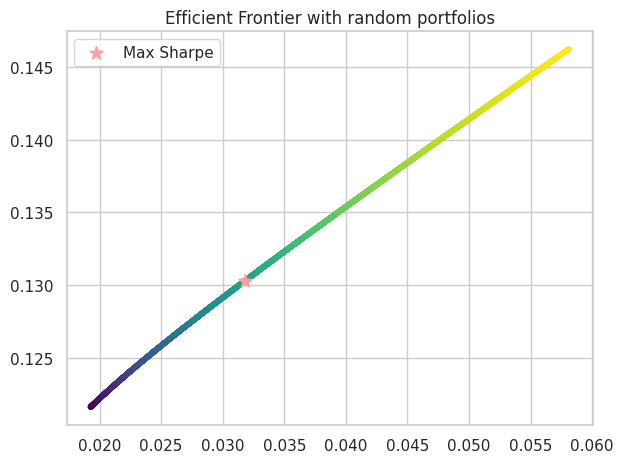

In [1865]:
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, plotting
import matplotlib.pyplot as plt
import numpy as np

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
#plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False,show_tickers =True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)

#w = ef2.max_sharpe()
w = ef2.max_quadratic_utility(risk_aversion=risk_aversion_b)
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
print(ret_tangent, std_tangent)

# Plot random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
#ef2.clean_weights(), mu, S

In [1866]:
ww = ef2.clean_weights()
weights_bonds = pd.Series(ww, index=ww.keys()).to_frame()

In [1867]:
aggr_bonds = pd.DataFrame({'Bonds':0},index = df.index)

In [1868]:
for column in ['Corporate Bonds','Government Bonds']:
  aggr_bonds['Bonds'] += weights_bonds.loc[column][0] * df[column] / df[column].iloc[0]

In [1869]:
mu_bonds= ret_tangent

In [1870]:
aggr_bonds

,Bonds
TRADEDATE,
2018-01-12,1.000000
2019-01-01,1.006529
2019-01-02,1.012205
2019-01-03,1.018834
2019-01-04,1.028302
...,...
2023-01-08,1.353441
2023-01-09,1.343649
2023-01-10,1.346395


Мы получили структуру портфеля облигаций, теперь перейдем к акциям. Методология создания портфеля акций будет несколько другой. Мы преполагаем, что для домохозяйства важна стабильность их инвестиционного портфеля, поэтому будем обращать внимание лишь на листинги первого уровня. Из них отберем те компании, для которых есть достаточное число значений котировок за последнее время. Будущая доходность оценивается по модели CAPM.

In [1871]:
import pandas as pd
import numpy as np

all_stocks = pd.read_excel('quotes.xlsx',sheet_name=2)

In [1872]:
all_stocks.set_index('TRADEDATE',inplace=True)

In [1873]:
all_stocks.index = pd.to_datetime(all_stocks.index)

In [1874]:
mu = mean_historical_return(all_stocks)
#for (columnName, columnData) in all_stocks.iteritems():
#  all_stocks[columnName] -= (1+mu[columnName]/252)**np.linspace(start=1,stop=1500,num=1499) / (1+mu[columnName]/252)**1500 * columnData[-1]
S1 = CovarianceShrinkage(all_stocks).ledoit_wolf(shrinkage_target='single_factor')


all_stocks = all_stocks.loc[:, all_stocks.columns!='MOEXBMI']

In [1875]:
S = exp_cov(all_stocks,frequency=252)

Используем скорректированный коэффициент $\beta$, так как известно, что в на очень большом временном горизонте он сходится к 1

In [1876]:
mu = RF + (0.33 + 0.67 * S1['MOEXBMI']/S1['MOEXBMI']['MOEXBMI']) * ERP
mu = mu.drop('MOEXBMI')

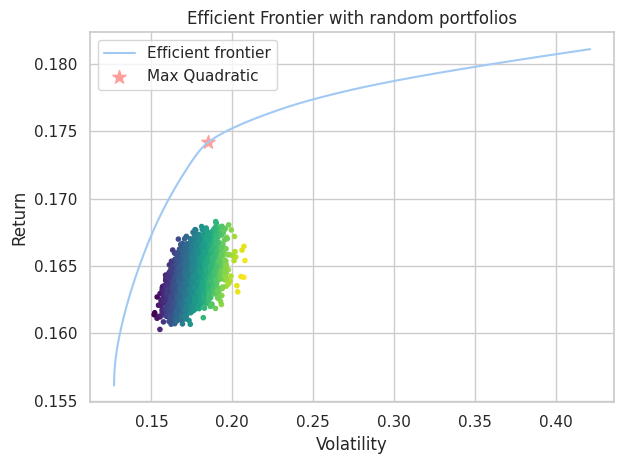

In [1877]:
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, plotting
import matplotlib.pyplot as plt
import numpy as np

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False,show_tickers =True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
print(ef2)
#w = ef2.max_sharpe()
w = ef2.max_quadratic_utility(risk_aversion=risk_aversion_4)
ret_tangent, std_tangent, _ = ef2.portfolio_performance()


# Plot random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Quadratic")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
#ef2.clean_weights(), mu, S

In [1878]:
ww = ef2.clean_weights()
weights_stocks = pd.Series(ww, index=ww.keys()).to_frame()

In [1879]:
weights_stocks[weights_stocks > 0].dropna()

,0
GAZP,0.22050
IRAO,0.12279
MTLRP,0.10598
ROSN,0.12521
SBER,0.30387
TATN,0.12165


In [1880]:
aggr_stocks = pd.DataFrame({'Stocks':0},index = all_stocks.index)

In [1881]:
for column in list(all_stocks):
  aggr_stocks['Stocks'] += weights_stocks.loc[column][0] * all_stocks[column] / all_stocks[column].iloc[0]

In [1882]:
mu_stocks= ret_tangent

In [1883]:
aggr_stocks.resample('M').interpolate().loc['2018-12-31':].to_numpy().flatten()

array([1.12768265, 1.14981743, 1.11561544, 1.1375062 , 1.15939696,
       1.26314866, 1.28261009, 1.30207152, 1.27750598, 1.25294043,
       1.33008887, 1.35022876, 1.37036865, 1.39050854, 1.21753013,
       1.04455173, 1.09025892, 1.10482545, 1.11939198, 1.15661532,
       1.13405319, 1.11376254, 1.14767643, 1.18159031, 1.23350114,
       1.28541196, 1.33732278, 1.3892336 , 1.36010208, 1.461389  ,
       1.5029613 , 1.56557206, 1.62818283, 1.798189  , 1.73732192,
       1.67645485, 1.66540049, 1.65434613, 1.39370387, 1.13306161,
       1.15407022, 1.17507883, 0.99353335, 1.04896895, 1.10440454,
       0.88355509, 0.90194603, 0.91087333, 0.92536935, 0.93986537,
       0.96693826, 1.08371624, 1.13518882, 1.1866614 , 1.20838606,
       1.2515697 , 1.29475335, 1.337937  , 1.38112064, 1.45887492,
       1.45887492])

Теперь остался последний шаг, объединить в один портфель акции и облигации

In [1884]:
df = pd.DataFrame({'Bonds':aggr_bonds['Bonds'],'Stocks':aggr_stocks.resample('M').interpolate().loc['2018-12-31':].to_numpy().flatten()/aggr_stocks.resample('M').interpolate().loc['2018-12-31':].to_numpy()[0][0]},index = df.index)

In [1885]:
df

,Bonds,Stocks
TRADEDATE,,
2018-01-12,1.000000,1.000000
2019-01-01,1.006529,1.019629
2019-01-02,1.012205,0.989299
2019-01-03,1.018834,1.008711
2019-01-04,1.028302,1.028123
...,...,...
2023-01-08,1.353441,1.148154
2023-01-09,1.343649,1.186448
2023-01-10,1.346395,1.224742


In [1886]:
mu = mean_historical_return(df,frequency=12)
S = exp_cov(df,frequency=12)

In [1887]:
mu['Stocks'] = mu_stocks
mu['Bonds'] = mu_bonds

In [1888]:
mu

Bonds     0.130269
Stocks    0.174190
dtype: float64

In [1889]:
S

,Bonds,Stocks
Bonds,0.001021,0.00192
Stocks,0.001920,0.05073


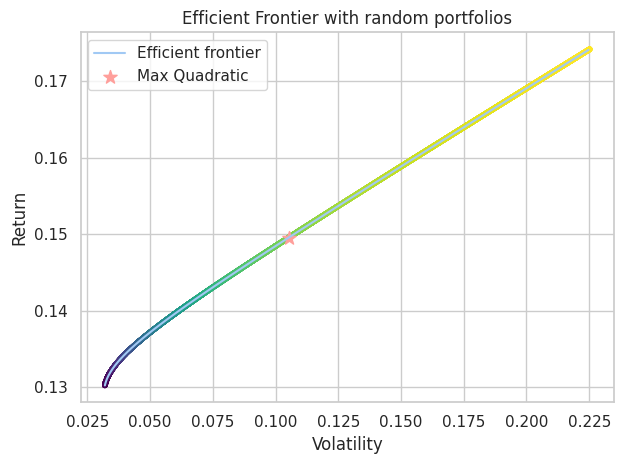

In [1890]:
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, plotting
import matplotlib.pyplot as plt
import numpy as np

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False,show_tickers =True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
print(ef2)
#w = ef2.max_sharpe()
w = ef2.max_quadratic_utility(risk_aversion=risk_aversion_5)
ret_tangent, std_tangent, _ = ef2.portfolio_performance()


# Plot random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Quadratic")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
#ef2.clean_weights(), mu, S

In [1891]:
ww = ef2.clean_weights()
weights = pd.Series(ww, index=ww.keys()).to_frame()

In [1892]:
mu_final = ret_tangent
std_final = std_tangent

In [1893]:
weights

,0
Bonds,0.5604
Stocks,0.4396


In [1894]:
mu_final, std_final

(0.149576220094167, 0.10521534278643004)

Осталось получить веса первоначальных активов:

In [1895]:
weights_state_bonds * weights_bonds.loc['Government Bonds'] * weights.loc['Bonds']

,0
RUGBITR1Y,0.359643
RUGBITR3Y,0.000000
RUGBITR5Y,0.000000
RUGBITR5+,0.003743


In [1896]:
weights_corp_bonds_AA * weights_corp_bonds.loc['Corporate Bonds AA'] *weights_bonds.loc['Corporate Bonds'] * weights.loc['Bonds']

,0
RUCBTRAA3YNS,0.197014
RUCBTRAA5YNS,0.000000


In [1897]:
weights_corp_bonds_AAA * weights_corp_bonds.loc['Corporate Bonds AAA'] *weights_bonds.loc['Corporate Bonds'] * weights.loc['Bonds']

,0
RUCBTR3A3YNS,0.0
RUCBTR3A5YNS,0.0


In [1898]:
weights_stocks[weights_stocks > 0].dropna() *  weights.loc['Stocks']

,0
GAZP,0.096932
IRAO,0.053978
MTLRP,0.046589
ROSN,0.055042
SBER,0.133581
TATN,0.053477


In [ ]:
# Bootstrapping portfolio size

Теперь сделаем бутстрап для итогового размера инвестиционного портфеля.